In [242]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch
import random, numpy as np, pandas as pd
from scipy.optimize import minimize
import scipy.cluster
import math

In [243]:
#Equally Weighted Portfolio
def ewPortfolio(n):
    return n*[1/n]

In [244]:
#Risk Parity
def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = np.dot(V,w.T)
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T)) # sum of squared error
    return J

def risk_parity(riskbudget,w0,V):
    x_t = riskbudget # your risk budget percent of total portfolio risk (equal risk)
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
    {'type': 'ineq', 'fun': long_only_constraint})
    res= minimize(risk_budget_objective, w0, args=[V,x_t],tol=0.000000000000001, method='SLSQP',constraints=cons) 
    return res.x

In [245]:
#Global minimum variance
def GMVPortfolio(covMatrix):
    return np.dot(np.linalg.inv(covMatrix),
                  np.ones(len(covMatrix)))/np.dot(np.dot(np.transpose(np.ones(len(covMatrix))),
                                                  np.linalg.inv(covMatrix)),np.ones(len(covMatrix)))

In [246]:
#Global minimum variance - long only
def GMVLOPortfolio(covMatrix):
    x0=pd.Series([1/len(covMatrix)]*len(covMatrix))
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
    {'type': 'ineq', 'fun': long_only_constraint})
    res = minimize(calculate_portfolio_var,x0,args=covMatrix,tol=0.000000000000001,method='SLSQP',constraints=cons)
    return res.x

In [247]:
#Inverse variance portfolio (Risk parity fra De Prado)
def getIVP(cov,**kargs):
    #Compute the inverse-variance portfolio
    ivp=1/np.diag(cov)
    ivp/=ivp.sum()
    return ivp

In [248]:
#Maximum diversification
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    return (np.dot(np.dot(w,V),w.T))

def calc_diversification_ratio(w, V):
    # average weighted vol
    w_vol = np.dot(np.sqrt(np.diag(V)), w.T)
    # portfolio vol
    port_vol = np.sqrt(calculate_portfolio_var(w, V))
    diversification_ratio = w_vol/port_vol
    # return negative for minimization problem (maximize = minimize -)
    return -diversification_ratio

def total_weight_constraint(x):
    return np.sum(x)-1

def long_only_constraint(x):
    return x

def max_div_port(w0, V, bnd=None, long_only=True):
    # w0: initial weight
    # V: covariance matrix
    # bnd: individual position limit
    # long only: long only constraint
    cons = ({'type': 'eq', 'fun': total_weight_constraint},)
    if long_only: # add in long only constraint
        cons = cons + ({'type': 'ineq', 'fun':  long_only_constraint},)
    res = minimize(calc_diversification_ratio, w0, bounds=bnd, args=V, method='SLSQP', constraints=cons)
    return res

In [249]:
#HRP2
#This version of HRP divides the weights between clusters

import collections
def flatten(x):
    if isinstance(x, collections.Iterable):
        return [a for i in x for a in flatten(i)]
    else:
        return [x]
    
def get_cluster_dict(link):
    link=np.append(link,np.array([[j] for j in range(int(link[-1,3]),int(link[-1,3])*2-1)]),axis=1)
    cluster_dict={}
    for i in link[:,0:5].astype(int):
        cluster_dict[i[4]]=[]
        if i[0]>=link[0,-1]:
            cluster_dict[i[4]].append(cluster_dict[i[0]])
        else:
            cluster_dict[i[4]].append(i[0])
        if i[1]>=link[0,-1]:
            cluster_dict[i[4]].append(cluster_dict[i[1]])
        else:
            cluster_dict[i[4]].append(i[1])
        
    return cluster_dict


def recClusterVar(cluster_dict,link, cov):
    link=np.append(link,np.array([[j] for j in range(int(link[-1,3]),int(link[-1,3])*2-1)]),axis=1)
    w=pd.Series(1,index=[i for i in range(int(link[0,-1]))]) #ændr i til i+1, hvis du skal køre main eller TestStabillity
    
    for i in reversed(link.astype(int)):
        if i[0]>=link[0,-1]:
            cluster1 = cluster_dict[i[0]]
        else:
            cluster1 = i[0]

        if i[1]>=link[0,-1]:
            cluster2 = cluster_dict[i[1]]
        else:
            cluster2 = i[1]
        
        cluster1=[i for i in flatten(cluster1)] #ændr i til i+1, hvis du skal køre main eller TestStabillity
        cluster2=[i for i in flatten(cluster2)] #ændr i til i+1, hvis du skal køre main eller TestStabillity
        c1_var=getClusterVar(cov,cluster1)
        c2_var=getClusterVar(cov,cluster2)
        alpha=1-c1_var/(c1_var+c2_var)
        w[cluster1]*=alpha # weight 1
        w[cluster2]*=1-alpha # weight 2
    return w

In [250]:
#HRP
def getClusterVar(cov,cItems):
    #Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int)
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] #number of original items
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) #make space
        df0=sortIx[sortIx>=numItems] # find clusters
        i = df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) # item 2
        sortIx=sortIx.sort_index() #re-sort
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)//2),(len(i)//2,len(i))) if len(i)>1] # bi-section
        for i in range(0,len(cItems),2):
            cItems0=cItems[i] # cluster 1
            cItems1=cItems[i+1] # cluster 2
            cVar0=getClusterVar(cov,cItems0)
            cVar1=getClusterVar(cov,cItems1)
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2
    w.sort_index(inplace=True)
    return w
    

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    #This is a proper diastance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist


def plotCorrMatrix(path,corr,labels=None):
    #Heatmap of the correlation matrix
    if labels is None: labels=[]
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.savefig(path)
    mpl.clf();mpl.close()  #reset pylab
    return
    
def generateData(nObs,size0,size1,sigma1,x=np.empty((0,1))):
    #Time series of correlated variables
    #1)generating some uncorrelated data
    np.random.seed(seed=12345);random.seed(12345)
    if len(x)==0:
        x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
    #2) creating correlation between the variables
    cols=[random.randint(0,size0-1) for i in range(size1)]
    q=np.random.normal(0,sigma1,size=(nObs,len(cols)))
    y=x[:,cols]+q
    x=np.append(x,y,axis=1)
    x=pd.DataFrame(x,columns=range(1,x.shape[1]+1))
    return x,cols

def generateAutocorrelatedData(nObs,correlation,size):
    x=np.random.normal(0,1,size=(1,size))
    for i in range(nObs-1):
        x=np.append(x,correlation*x[i]+np.random.normal(0,1,size=(1,size)),axis=0)
    return x

def generateCauchyDistData(nObs,size):
    x=np.random.standard_cauchy(size=(nObs,size))
    return pd.DataFrame(x)

def generateT_DistData(nObs,size,df):
    x=np.random.standard_t(df,size=(nObs,size))
    return pd.DataFrame(x)
    
def findCorrelatedCols(colnbs,size0):
    keys = list(set([i[0] for i in colnbs]))
    for i in range(1,size0+1):
        if i not in keys:
            keys.append(i)     
    keys.sort()
    clusters={key: [key] for key in keys}
    for i in colnbs:
        clusters[i[0]].append(i[1])
    return clusters

def clusterWeights(clusters, hrp):
    weights={key:None for key in clusters.keys()}
    for i in weights:
        weights[i] = sum([hrp.loc[j] for j in clusters[i]])
    return list(weights.values())
    
    
def main():
    #1) Generate correlated data
    nObs, size0,size1,sigma1,correlation = 1000,10,10,0.75,-1
    #x = generateAutocorrelatedData(nObs,correlation,size0)
    x, cols=generateData(nObs,size0,size1,sigma1)
    print(findCorrelatedCols([(j+1,size0+i) for i,j in enumerate(cols,1)],size0))
    cov,corr=x.cov(),x.corr()
    # 2) compute and plot correl matrix
    #corr=pd.DataFrame(np.array([[1,0.7,0.2],[0.7,1,-0.2],[0.2,-0.2,1]]))
    plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
    # 3) cluster
    dist=correlDist(corr)
    link=sch.linkage(dist,'single')
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() #recover labels
    df0=corr.loc[sortIx,sortIx] #re-order
    plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx)
    #5) Capital allocation HRP2
    cluster_dict = get_cluster_dict(link)
    hrp2 = recClusterVar(cluster_dict,link, cov)
    plot_weights(hrp, hrp2, cov, x)
    scipy.cluster.hierarchy.dendrogram(link, labels=[i+1 for i in range(size0+size1)])
    
    return hrp


def testStability():
    nObs, size0,size1,sigma1,recalc_time, samplesize,correlation = 528,5,5,0.5,22,264,0
    #x = generateAutocorrelatedData(nObs,correlation,size0)
    x,cols=generateData(nObs,size0,size1,sigma1)
    clusters=findCorrelatedCols([(j+1,size0+i) for i,j in enumerate(cols,1)],size0)
    clusterweights=[]
    weights=[]
    weights2=[]
    print(clusters)
    for i in range(int((nObs-samplesize)/recalc_time)+1):
        x_sample = x.iloc[i*recalc_time:samplesize+recalc_time*i]
        cov,corr=x_sample.cov(),x_sample.corr()
        dist=correlDist(corr)
        link=sch.linkage(dist,'single')
        sortIx=getQuasiDiag(link)
        sortIx=corr.index[sortIx].tolist() #recover labels
        df0=corr.loc[sortIx,sortIx] #re-order
        hrp=getRecBipart(cov,sortIx)
        cluster_dict = get_cluster_dict(link)
        hrp2 = recClusterVar(cluster_dict,link, cov)
        #plotCorrMatrix('HRP3_corr{}.png'.format(i),df0,labels=df0.columns)
        clusterweights.append(clusterWeights(clusters,hrp))
        weights.append(list(hrp.sort_index().values))
        weights2.append(hrp2.values)
    return pd.DataFrame(weights), pd.DataFrame(weights2)
    return pd.DataFrame(clusterweights)

In [251]:
def risk_contribution(weights,cov):
    portvar = np.dot(np.dot(weights,cov),weights.T)
    rc=[(weights[i]*np.dot(cov,weights)[i])/portvar for i in range(len(weights))]
    return rc

In [252]:
#Barplots of allocations
def plot_weights(hrp, hrp2, cov, data):
    index = list(data.columns)
    
    #HRP
    hrp = hrp.sort_values(ascending=False)
    hrp.plot.bar(figsize = (15,7))
    mpl.title("HRP")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((0, 0.5))
    mpl.show()
    
    #HRP2
    hrp2 = hrp2.sort_values(ascending=False)
    hrp2.plot.bar(figsize = (15,7))
    mpl.title("HRP2")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((0, 0.5))
    mpl.show()

    #Naive Risk-Parity
    ivp = getIVP(cov)
    ivp = pd.Series(ivp, index=index)
    ivp = ivp.sort_values(ascending=False)
    ivp.plot.bar(figsize = (15,7))
    mpl.title("Naive Risk parity (IVP)")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((0,0.5))
    mpl.show()
    
    #Risk Parity
    rp = risk_parity(np.array([1/len(cov)]*len(cov)),np.array([1/len(cov)]*len(cov)),cov).x
    rp = pd.Series(rp, index=index)
    rp = rp.sort_values(ascending=False)
    rp.plot.bar(figsize = (15,7))
    mpl.title("Risk Parity")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((0, 0.5))
    mpl.show()
    
    #GMV
    gmv = GMVPortfolio(cov)
    gmv = pd.Series(gmv, index=index)
    gmv = gmv.sort_values(ascending=False)
    gmv.plot.bar(figsize = (15,7))
    mpl.title("GMV")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((-0.2, 0.5))
    mpl.show()
    
    #GMV Long-only
    gmvlo = GMVLOPortfolio(cov)
    gmvlo = pd.Series(gmvlo, index=index)
    gmvlo = gmvlo.sort_values(ascending = False)
    gmvlo.plot.bar(figsize=(15,7))
    mpl.title("GMV Long-only")
    mpl.ylabel("weight")
    mpl.xlabel("Asset")
    mpl.ylim((0,0.5))
    mpl.show()
    
    
    #Maximum_Div_port
    mdv = pd.Series(max_div_port(np.array([1/len(cov)]*len(cov)),cov).x, index=index)
    mdv = mdv.sort_values(ascending=False)
    mdv.plot.bar(figsize = (15,7))
    mpl.title("Maximum Diversification Portfolio")
    mpl.ylabel("Weight")
    mpl.xlabel("Asset")
    mpl.ylim((-0.1, 0.5))
    mpl.show()

In [ ]:
main()

In [ ]:
#data fra excel fil arp_strategies
for i in range(5):
    arp_data = pd.read_excel("arp_strategies.xlsx", sheet_name="S_{}".format(i+1))
    arp_data = arp_data.iloc[2611:] #nogle strategier starter først fra 2005, så de første 2611 rækker fjernes
    arp_data = arp_data.drop(['Date'], axis=1)
    if i == 0:
        arp_data_samlet = arp_data
    else:
        arp_data_samlet = pd.merge(arp_data_samlet,arp_data,right_index = True, left_index = True)

arp_data = arp_data_samlet    
del arp_data_samlet
arp_data.head()

In [253]:
#data fra excel fil Betting against beta
#den seneste faktor data starter d. 7/3/1989, som er forskellige rækker i nogle af datasættet
dates = pd.read_excel('Betting Against Beta Equity Factors Daily.xlsx','MKT',skiprows=17020,usecols='A', header = 0)
dates.columns=['Date']
dates=pd.Series(dates['Date'])
dd= pd.to_datetime(dates)

sheet_names=['MKT','SMB','HML FF','HML Devil']
for i in sheet_names:
    faktor_data = pd.read_excel('Betting Against Beta Equity Factors Daily.xlsx',i, skiprows=17021, usecols='AC')
    if i == 'MKT':
        data_samlet = faktor_data
    else:
        data_samlet = pd.merge(data_samlet,faktor_data,right_index = True, left_index = True)

#Henter UMD
umd_data = pd.read_excel('Betting Against Beta Equity Factors Daily.xlsx','UMD', skiprows=16871, usecols='AC')
data_samlet = pd.merge(data_samlet,umd_data,right_index = True, left_index = True)

#Henter BAB
bab_data = pd.read_excel('Betting Against Beta Equity Factors Daily.xlsx','BAB Factors', skiprows=15712, usecols='AC')
data_samlet = pd.merge(data_samlet,bab_data,right_index = True, left_index = True)

#Henter QMJ
qmj_data = pd.read_excel('Quality Minus Junk Factors Daily.xlsx','QMJ Factors', skiprows=8112, usecols='AC')
data_samlet = pd.merge(data_samlet,qmj_data,right_index = True, left_index = True)

sheet_names=['MKT','SMB','HML FF','HML Devil', 'UMD', 'BAB Factors','QMJ Factors']
faktor_data = data_samlet        
faktor_data.columns = sheet_names
faktor_data.head()

,MKT,SMB,HML FF,HML Devil,UMD,BAB Factors,QMJ Factors
0,0.002759,-2.122874e-03,-3.330909e-04,1.297087e-04,1.049973e-03,-0.000595,1.054038e-03
1,-0.000319,6.838130e-07,1.064573e-07,-4.689554e-08,-3.468095e-07,-0.000264,-3.467870e-07
2,0.003748,-2.015496e-03,-8.678472e-04,-1.153169e-03,1.758859e-03,-0.000116,-1.249981e-03
3,0.003382,3.035641e-03,-5.548654e-04,-1.948233e-03,2.183329e-03,0.000259,-1.166859e-04
4,0.008716,-4.271428e-03,-1.928756e-03,-2.305753e-03,6.773260e-03,-0.000361,2.508294e-04


In [ ]:
dates = pd.read_excel('Betting Against Beta Equity Factors Daily.xlsx','MKT',skiprows=18434,usecols='A', header = 0)
dates.columns=['Date']
dates=pd.Series(dates['Date'])
dd= pd.to_datetime(dates)

#Henter alle lande i MKT
mkt_data = pd.read_excel('Betting Against Beta Equity Factors Daily.xlsx','MKT', skiprows=18434, usecols='B:Y')
mkt_global = pd.read_excel('Betting Against Beta Equity Factors Daily.xlsx','MKT', skiprows=18434, usecols='Z', header=0) #Global som benchmark?
mkt_data.columns = ['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'DEU', 'DNK', 'ESP', 'FIN', 'FRA', 'GBR', 'GRC', 'HKG', 'IRL', 'ISR', 'ITA', 'JPN', 'NLD', 'NOR', 'NZL', 'PRT', 'SGP', 'SWE', 'USA']

In [ ]:
arp_data = faktor_data
arp_data.head()

,MKT,SMB,HML FF,HML Devil,UMD,BAB Factors,QMJ Factors
0,0.002759,-2.122874e-03,-3.330909e-04,1.297087e-04,1.049973e-03,-0.000595,1.054038e-03
1,-0.000319,6.838130e-07,1.064573e-07,-4.689554e-08,-3.468095e-07,-0.000264,-3.467870e-07
2,0.003748,-2.015496e-03,-8.678472e-04,-1.153169e-03,1.758859e-03,-0.000116,-1.249981e-03
3,0.003382,3.035641e-03,-5.548654e-04,-1.948233e-03,2.183329e-03,0.000259,-1.166859e-04
4,0.008716,-4.271428e-03,-1.928756e-03,-2.305753e-03,6.773260e-03,-0.000361,2.508294e-04


In [ ]:
#Henter data.csv
data2 = pd.read_csv('data.csv')
data2.columns
data2.drop(['gvkey', 'iid', 'datadate','cusip','conm','cheqv','divd','divsp','ajexdi','cshoc','cshtrd','prccd','prchd','prcod','trfd','ggroup','gind','gsector','gsubind','naics','sic'], axis=1, inplace=True)
data2.head()

In [ ]:
def main_2():
    #1) data
    x = arp_data
    cov,corr=x.cov(),x.corr()
    # 2) compute and plot correl matrix
    #corr=pd.DataFrame(np.array([[1,0.7,0.2],[0.7,1,-0.2],[0.2,-0.2,1]]))
    plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
    # 3) cluster
    dist=correlDist(corr)
    link=sch.linkage(dist,'median')
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() #recover labels
    df0=corr.loc[sortIx,sortIx] #re-order
    plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx)
    
    cluster_dict = get_cluster_dict(link)
    hrp2 = recClusterVar(cluster_dict,link, cov)
    
    plot_weights(hrp, hrp2, cov, x)
    mpl.figure(figsize=[20,10])
    scipy.cluster.hierarchy.dendrogram(link)#, labels=sortIx)
    
    
    return hrp

In [ ]:
main_2()

In [269]:
def main_3():
    #Formålet er at se hvordan vægtene i porteføljen udvikler sig over tid.
    re_calc_time,sample_size = 60,360
    x = pd.DataFrame(arp_data)
    #Nye
    HRP_portfolio_return=[]
    RP_portfolio_return=[]
    RiskP_portfolio_return=[]
    GMV_portfolio_return=[]
    GMVLO_portfolio_return=[]
    MD_portfolio_return=[]
    EW_portfolio_return=[]
    HRP2_portfolio_return=[]
    
    hrp_weights=[]
    hrp2_weights=[]
    gmv_weights=[]
    mdv_weights=[]
    ivp_weights=[]
    rp_weights=[]
    gmvlo_weights=[]
    
    EW_weight=[1/len(arp_data.columns)]*len(arp_data.columns)
    returns=[]
    
    for i in range(int((len(arp_data)-sample_size)/re_calc_time)+2):
        #Henter data
        x_sample = x.iloc[int(i*re_calc_time):int(i*re_calc_time)+sample_size] 
        cov,corr=x_sample.cov().reset_index(drop=True) ,x_sample.corr().reset_index(drop=True)
        cov.columns, corr.columns = [i for i in range(len(cov))], [i for i in range(len(cov))]
        #HRP
        dist=correlDist(corr)
        link=sch.linkage(dist,'single')
        sortIx=getQuasiDiag(link)
        sortIx=corr.index[sortIx].tolist() #recover labels
        df0=corr.loc[sortIx,sortIx]
        plotCorrMatrix('HRP3_corr{}.png'.format(i),df0,labels=df0.columns)
        hrp=getRecBipart(cov,sortIx).sort_index()
        #HRP2
        cluster_dict = get_cluster_dict(link)
        hrp2 = recClusterVar(cluster_dict,link, cov)
        #IVP
        ivp = getIVP(cov)
        #GMV
        gmv = GMVPortfolio(cov)
        #GMV Long-only
        gmvlo = GMVLOPortfolio(cov)
        #MD
        mdv = pd.Series(max_div_port(np.array([1/len(cov)]*len(cov)),cov).x)
        #Risk Parity
        rp = pd.Series(risk_parity(np.array([1/len(cov)]*len(cov)),np.array([1/len(cov)]*len(cov)),cov))
        hrp_weights.append(hrp)
        hrp2_weights.append(hrp2)
        gmv_weights.append(gmv)
        gmvlo_weights.append(gmvlo)
        mdv_weights.append(mdv)
        ivp_weights.append(ivp)
        rp_weights.append(rp)
        
        if i ==int((len(arp_data)-sample_size)/re_calc_time):
            return pd.DataFrame(HRP_portfolio_return), pd.DataFrame(RP_portfolio_return), pd.DataFrame(GMV_portfolio_return), pd.DataFrame(GMVLO_portfolio_return), pd.DataFrame(MD_portfolio_return),pd.DataFrame(EW_portfolio_return), pd.DataFrame(HRP2_portfolio_return), pd.DataFrame(RiskP_portfolio_return), pd.DataFrame(returns),pd.DataFrame(hrp_weights),pd.DataFrame(hrp2_weights),pd.DataFrame(gmv_weights),pd.DataFrame(mdv_weights),pd.DataFrame(ivp_weights), pd.DataFrame(rp_weights), pd.DataFrame(gmvlo_weights)
        

        for j in range(int(re_calc_time)):
            
            HRP_portfolio_return.append(np.dot(hrp,arp_data.iloc[sample_size+(i)*int(re_calc_time)+j]))
            RP_portfolio_return.append(np.dot(ivp,arp_data.iloc[sample_size+(i)*int(re_calc_time)+j]))
            GMV_portfolio_return.append(np.dot(gmv,arp_data.iloc[sample_size+(i)*int(re_calc_time)+j]))
            GMVLO_portfolio_return.append(np.dot(gmvlo,arp_data.iloc[sample_size+(i)*int(re_calc_time)+j]))
            MD_portfolio_return.append(np.dot(mdv,arp_data.iloc[sample_size+(i)*int(re_calc_time)+j]))
            EW_portfolio_return.append(np.dot(EW_weight,arp_data.iloc[sample_size+(i)*int(re_calc_time)+j]))
            HRP2_portfolio_return.append(np.dot(hrp2,arp_data.iloc[sample_size+(i)*int(re_calc_time)+j]))
            RiskP_portfolio_return.append(np.dot(rp,arp_data.iloc[sample_size+(i)*int(re_calc_time)+j]))
    return -9

In [270]:
def value_at_risk(returns, confidence_level=.05):
    return returns.quantile(confidence_level, interpolation='higher')


def expected_shortfall(returns, confidence_level=.05):
    var = value_at_risk(returns, confidence_level)

    return returns[returns.lt(var)].mean()

In [271]:
HRP_weights,RP_weights,GMV_weights,GMVLO_weights,MD_weights,EW_weights,HRP2_weights, RiskP_weights, returns, hrp_weights, hrp2_weights, gmv_weights, mdv_weights, ivp_weights, rp_weights, gmvlo_weights = main_3()

/Users/magnustveter/Documents/Nordnet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


In [272]:
#HRP_weighted_returns = (HRP_weights*returns)
HRP_portfolio_returns = HRP_weights
HRP_cumulative_returns = (HRP_portfolio_returns + 1).cumprod()
HRP_cumulative_returns['dates']=dd
HRP_cumulative_returns.set_index('dates',inplace=True,drop=True)


#HRP2
HRP2_portfolio_returns = HRP2_weights
HRP2_cumulative_returns = (HRP2_portfolio_returns +1).cumprod()
HRP2_cumulative_returns['dates']=dd
HRP2_cumulative_returns.set_index('dates',inplace=True,drop=True)

#RP_weighted_returns = (RP_weights*returns)
RP_portfolio_returns = RP_weights
RP_cumulative_returns = (RP_portfolio_returns + 1).cumprod()
RP_cumulative_returns['dates']=dd
RP_cumulative_returns.set_index('dates',inplace=True,drop=True)

#RiskP
RiskP_portfolio_returns = RiskP_weights
RiskP_cumulative_returns = (RiskP_portfolio_returns + 1).cumprod()
RiskP_cumulative_returns['dates']=dd
RiskP_cumulative_returns.set_index('dates',inplace=True,drop=True)

#GMV_weighted_returns = (GMV_weights*returns)
GMV_portfolio_returns = GMV_weights
GMV_cumulative_returns = (GMV_portfolio_returns + 1).cumprod()
GMV_cumulative_returns['dates']=dd
GMV_cumulative_returns.set_index('dates',inplace=True,drop=True)

#GMVLO_weighted_returns = (GMV_weights*returns)
GMVLO_portfolio_returns = GMVLO_weights
GMVLO_cumulative_returns = (GMVLO_portfolio_returns + 1).cumprod()
GMVLO_cumulative_returns['dates']=dd
GMVLO_cumulative_returns.set_index('dates',inplace=True,drop=True)

#MD_weighted_returns = (MD_weights*returns)
MD_portfolio_returns = MD_weights
MD_cumulative_returns = (MD_portfolio_returns + 1).cumprod()
MD_cumulative_returns['dates']=dd
MD_cumulative_returns.set_index('dates',inplace=True,drop=True)

#EW_weighted_returns = (EW_weights*returns)
EW_portfolio_returns = EW_weights
EW_cumulative_returns = (EW_portfolio_returns + 1).cumprod()
EW_cumulative_returns['dates']=dd
EW_cumulative_returns.set_index('dates',inplace=True,drop=True)


#global
#mkt_global_cumulative_returns = (mkt_global + 1).cumprod()
#mkt_global_cumulative_returns['dates']=dd
#mkt_global_cumulative_returns.set_index('dates',inplace=True,drop=True)

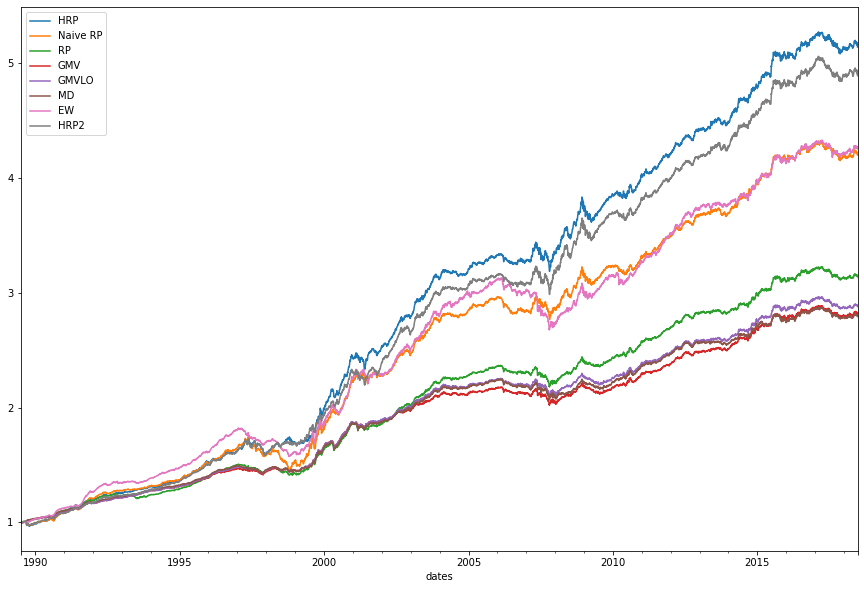

In [273]:
ax = HRP_cumulative_returns.plot(figsize=[15,10])
RP_cumulative_returns.plot(figsize=[15,10], ax=ax)
RiskP_cumulative_returns.plot(figsize=[15,10],ax=ax)
GMV_cumulative_returns.plot(figsize=[15,10], ax=ax)
GMVLO_cumulative_returns.plot(figsize=[15,10], ax=ax)
MD_cumulative_returns.plot(figsize=[15,10], ax=ax)
EW_cumulative_returns.plot(figsize=[15,10], ax=ax)
HRP2_cumulative_returns.plot(figsize=[15,10], ax=ax)

#mkt_global_cumulative_returns.plot(figsize=[15,10], ax=ax)

mpl.legend(['HRP', 'Naive RP','RP', 'GMV','GMVLO', 'MD','EW','HRP2', 'Global'])
mpl.show()
#Hvordan får vi de rigtige datoer på x akse?

In [260]:
allo_comp = [[HRP_portfolio_returns.mean()[0], HRP2_portfolio_returns.mean()[0], RP_portfolio_returns.mean()[0], GMV_portfolio_returns.mean()[0], GMVLO_portfolio_returns.mean()[0], MD_portfolio_returns.mean()[0],RiskP_portfolio_returns.mean()[0] ,EW_portfolio_returns.mean()[0]]]
allo_comp.append([HRP_portfolio_returns.std()[0], HRP2_portfolio_returns.std()[0], RP_portfolio_returns.std()[0], GMV_portfolio_returns.std()[0], GMVLO_portfolio_returns.std()[0],MD_portfolio_returns.std()[0],RiskP_portfolio_returns.std()[0],EW_portfolio_returns.std()[0]])
allo_comp.append([expected_shortfall(HRP_portfolio_returns)[0], expected_shortfall(HRP2_portfolio_returns)[0], expected_shortfall(RP_portfolio_returns)[0], expected_shortfall(GMV_portfolio_returns)[0], expected_shortfall(GMVLO_portfolio_returns)[0], expected_shortfall(MD_portfolio_returns)[0],expected_shortfall(RiskP_portfolio_returns)[0], expected_shortfall(EW_portfolio_returns)[0]])


In [261]:
allo_comp=pd.DataFrame(allo_comp, columns=['HRP', 'HRP2','Naive RP','GMV','GMVLO','MD','Risk Parity','EW'],index=['mean return','std','expected shortfall'])
allo_comp.loc['Sharpe Ratio']=allo_comp.loc['mean return']/allo_comp.loc['std']
#Expected shortfall 14 dage
N = 14

HRP_portfolio_returns14 = HRP_portfolio_returns.groupby(HRP_portfolio_returns.index // N).sum()
HRP_portfolio_returns.groupby(HRP_portfolio_returns.index // N).sum()
HRP2_portfolio_returns14 = HRP_portfolio_returns.groupby(HRP_portfolio_returns.index // N).sum()
RP_portfolio_returns14 = RP_portfolio_returns.groupby(RP_portfolio_returns.index // N).sum()
GMV_portfolio_returns14 = GMV_portfolio_returns.groupby(GMV_portfolio_returns.index // N).sum()
GMVLO_portfolio_returns14 = GMVLO_portfolio_returns.groupby(GMVLO_portfolio_returns.index // N).sum()
MD_portfolio_returns14 = MD_portfolio_returns.groupby(MD_portfolio_returns.index // N).sum()
RiskP_portfolio_returns14 = RiskP_portfolio_returns.groupby(RiskP_portfolio_returns.index // N).sum()
EW_portfolio_returns14 = EW_portfolio_returns.groupby(EW_portfolio_returns.index // N).sum()
allo_comp.loc['Expected shortfall 14 days'] = [expected_shortfall(HRP_portfolio_returns14)[0], expected_shortfall(HRP2_portfolio_returns14)[0], expected_shortfall(RP_portfolio_returns14)[0], expected_shortfall(GMV_portfolio_returns14)[0], expected_shortfall(GMVLO_portfolio_returns14)[0], expected_shortfall(MD_portfolio_returns14)[0], expected_shortfall(RiskP_portfolio_returns14)[0],expected_shortfall(EW_portfolio_returns14)[0]]
allo_comp

,HRP,HRP2,Naive RP,GMV,GMVLO,MD,Risk Parity,EW
mean return,0 0.000208 dtype: float64,0 0.000203 dtype: float64,0 0.000187 dtype: float64,0 0.000132 dtype: float64,0 0.000135 dtype: float64,0 0.000132 dtype: float64,0 0.00015 dtype: float64,0 0.000192 dtype: float64
std,0 0.001774 dtype: float64,0 0.001779 dtype: float64,0 0.001868 dtype: float64,0 0.001195 dtype: float64,0 0.001198 dtype: float64,0 0.00124 dtype: float64,0 0.001271 dtype: float64,0 0.001781 dtype: float64
expected shortfall,0 -0.003967 dtype: float64,0 -0.004091 dtype: float64,0 -0.004248 dtype: float64,0 -0.002644 dtype: float64,0 -0.002649 dtype: float64,0 -0.002769 dtype: float64,0 -0.002881 dtype: float64,0 -0.004155 dtype: float64
Sharpe Ratio,0 0.11728 dtype: float64,0 0.113852 dtype: float64,0 0.10019 dtype: float64,0 0.11034 dtype: float64,0 0.112495 dtype: float64,0 0.106639 dtype: float64,0 0.118245 dtype: float64,0 0.107991 dtype: float64
Expected shortfall 14 days,0 -0.013619 dtype: float64,0 -0.013619 dtype: float64,[-0.016508292329492278],[-0.008773136915417498],[-0.008848328147300261],[-0.009530624681194543],[-0.010554272268523901],[-0.017054287056932065]


In [ ]:
HRP_weights.columns = arp_data.columns
weight_stats=pd.DataFrame()
weight_stats['mean'] = HRP_weights.mean()
weight_stats['std.dev'] = HRP_weights.std()
weight_stats['variance'] = HRP_weights.var()
weight_stats.T

In [ ]:
rene_strategier=(arp_data.iloc[262:]+1).cumprod()

In [ ]:
rene_strategier.plot(figsize=(15,7))

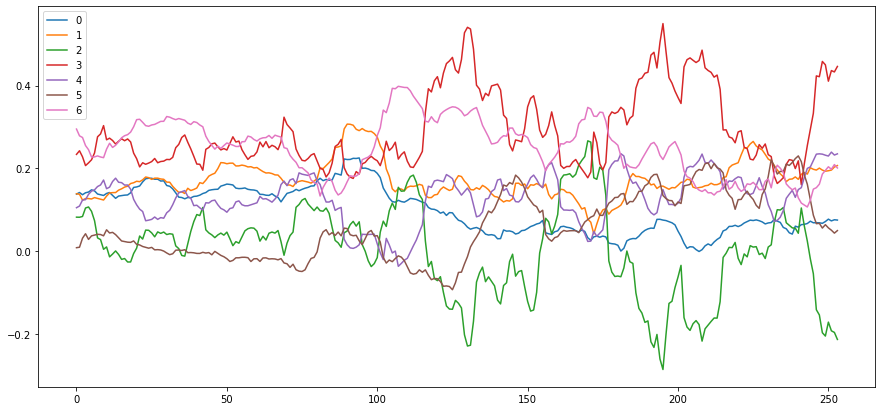

In [262]:
gmv_weights.plot(figsize=(15,7))

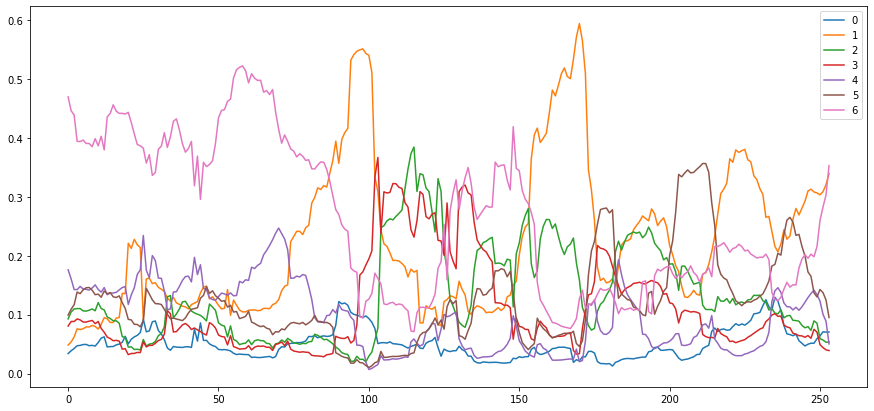

In [263]:
hrp2_weights.plot(figsize=(15,7))

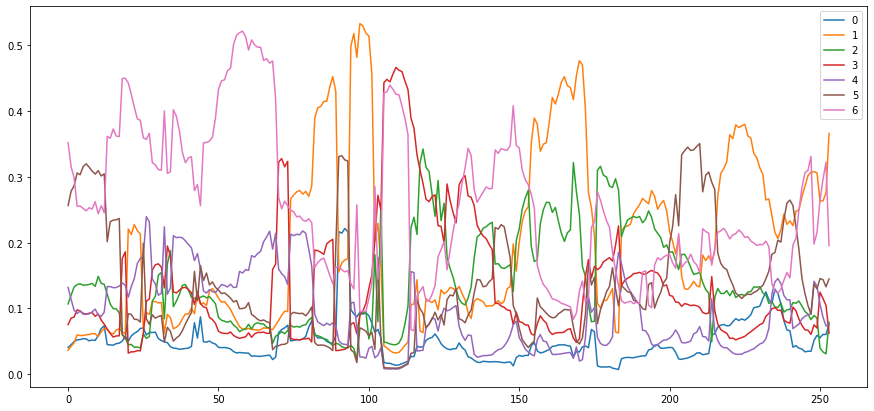

In [264]:
hrp_weights.plot(figsize=(15,7))

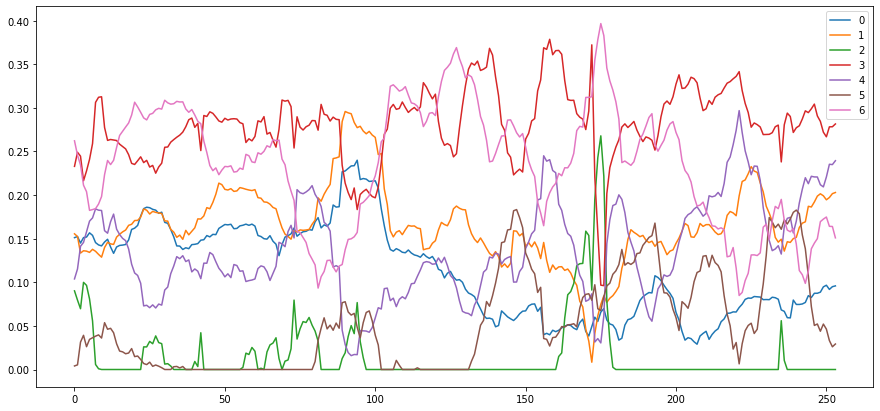

In [265]:
mdv_weights.plot(figsize=(15,7))

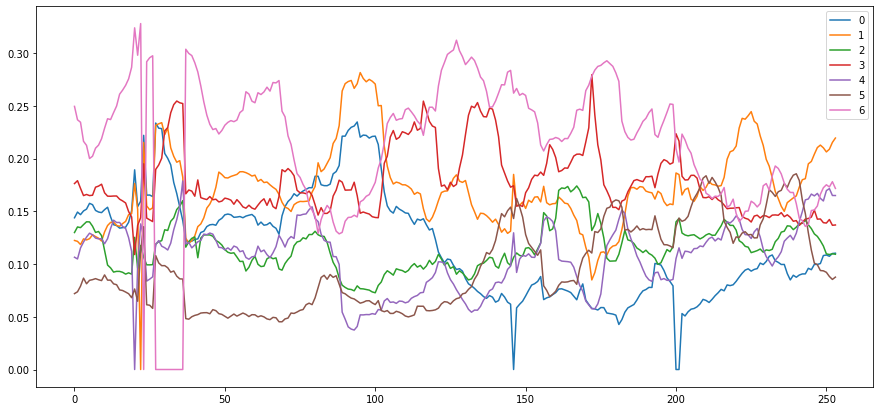

In [266]:
rp_weights.plot(figsize=(15,7))

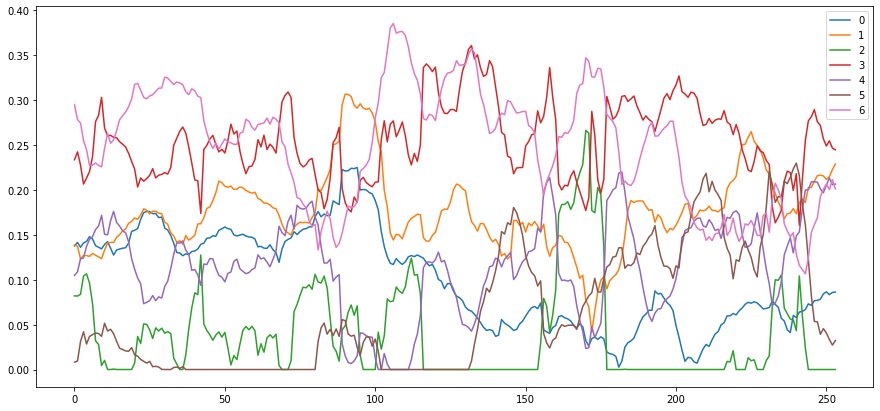

In [267]:
gmvlo_weights.plot(figsize=(15,7))

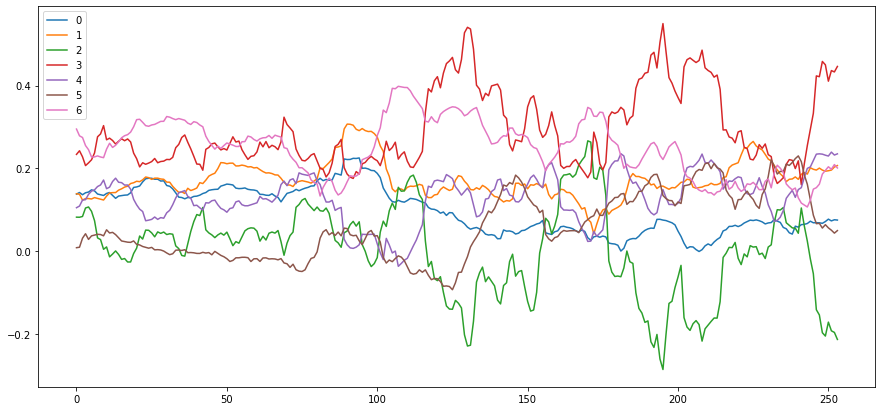

In [268]:
gmv_weights.plot(figsize=(15,7))